# Reinforcement Learning, Part 4: Model-Based RL

In model-based RL, the agent has an internal model of the environment, and uses the internal model to update its $Q$-value functions.

## One-step $Q$-planning

The simplest example of model-based RL is one-step $Q$-planning (1SQP).  In 1SQP, the agent fills in its own $Q$-tables by simulating the environment multiple times. 

In [1]:
import random
import numpy as np
from copy import copy
import matplotlib.pyplot as plt 

class Maze():
    """A maze environment"""

    ACTIONS = ("up", "down", "left", "right") # List of actions
    INITIAL_STATE = (0, 0) # Always starts at the topleft corner
    
    def __init__(self, fname = "grid.txt"):
        """Inits a maze by loading the grid file"""
        self.grid = np.loadtxt(fname)
        self.state = self.INITIAL_STATE
        self.end = False


    def state_transition(self, state1, action1):
        "Defines the next state gien the "
        s = state1
        state2 = copy(state1)
        
        if action1 in self.ACTIONS:
            if action1 == "up":
                if s[0] > 0:
                    state2 = (s[0] - 1, s[1])
            
            elif action1 == "left":
                if s[1] > 0:
                    state2 = (s[0], s[1] - 1)
            
            elif action1 == "down":
                if s[0] < (self.grid.shape[0] - 1):
                    state2 = (s[0] + 1, s[1])

            elif action1 == "right":
                if s[1] < (self.grid.shape[1] - 1):
                    state2 = (s[0], s[1] + 1)
                    
        return state2
                    
    
    def reward_transition(self, state1, action1, state2):
        """Reward is -1 for bouncing against the walls, and whatever is on the grid otherwise"""
        if state1 == state2:
            return -1
        else:
            return self.grid[state2[0], state2[1]]
        
    
    # Quick way to combine State transitions and Reward transitions 
    def transition(self, action1):
        """Changes the state following an action"""
        state1 = self.state
        state2 = self.state_transition(state1, action1)
        reward2 = self.reward_transition(state1, action1, state2)
        
        self.state = state2
        return (state2, reward2) # Returns s_t+1, r_t+1

    
    def print_state(self):
        "Prints a text representation of the maze (with the agent position)"
        bar = "-" * ( 4 * self.grid.shape[1] + 1)
        for i in range(self.grid.shape[0]):
            row = "|"
            for j in range(self.grid.shape[1]):
                cell = " "
                if i == self.state[0] and j == self.state[1]:
                    cell = "*"
                row += (" %s |" % cell)
            print(bar)
            print(row)
        print(bar)

## The MB-Agent

And now, the agent. In addition to the $Q$-table, the new agent has a model of the environment. The model will be represented as an $S$-table, a table of $(s_t, a_t)$ associations with the consequences $(s_{t+1}, r_{t+1})$. The model needs to have an internal model of the enviroment (the $S$-table) to start with. The table is created by passing the environment to an agent's function called `initS`. 

In [2]:
import random
import numpy as np

class MBAgent():
    def __init__(self, actions=Maze.ACTIONS, epsilon=0.1, alpha=0.1, gamma=0.9):
        """Creates a Q-agent"""
        self.Q = {}    ## Initial dictionary of (s, a) pairs. At the beginning, it's emtpy.
        self.S = {}
        self.epsilon = epsilon     # Epsilon for e-greey policy
        self.alpha = alpha         # Learning rate
        self.gamma = gamma         # Temporal discounting
        self.actions = actions     # Set of possible actions (provide those of Maze.ACTIONS)
        
        
    def init_states(self, environment = Maze()):
        """Initializes the model of the environment"""
        states = [(row, col) for row in range(4) for col in range(4)]
        actions = self.actions
        
        # All possible transitions
        for state1 in states:
            for action1 in actions:
                # For every state and every action, predict the consequence
                state2 = environment.state_transition(state1, action1)
                reward2 = environment.reward_transition(state1, action1, state2)
                
                # Update the S-table
                self.S[(state1, action1)] = (state2, reward2)
        

    def q_planning(self, n = 1000):
        """Plans ahead and learns the Q-table"""
        for j in range(n):
            start = random.choice(tuple(self.S.keys()))
            state2, reward2 = self.S[start]
            state1, action1 = start
            self.q_learning(state1, action1, reward2, state2)

        
    def policy(self, state):
        """Selects an action with a epsilon-greedy policy"""
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q = [self.Q[(state, a)] if (state, a) in self.Q.keys() else 0.0 for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    
    def q_learning(self, state1, action1, reward2, state2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha
        
        q1 = 0.0
        
        if (state1, action1) in self.Q.keys():
            q1 = self.Q[(state1, action1)]
        
        max_q2 = max([self.Q[(state2, a)] if (state2, a) in self.Q.keys() else 0.0 for a in self.actions])
        
        rpe = reward2 + g * max_q2 - q1
        q1 += a * rpe
        self.Q[(state1, action1)] = q1

            
def plot_q_table(agent, **kwargs):
    """Visualizes the Q tables, one per action"""
    fig, axs = plt.subplots(2, 2, figsize=(5,5))
    i = 0
    for a in agent.actions:
        # Create the corresponding state table
        data = np.zeros((4,4))
        states = [x for x in agent.Q.keys() if x[1] == a]
            
        for s in states:
            x, y = s[0]
            data[x, y] = agent.Q[s]
        
        # Plot the heatmap
        im = axs.flat[i].imshow(data, **kwargs, cmap="viridis")
        axs.flat[i].set_xticks(np.arange(data.shape[1]))
        axs.flat[i].set_yticks(np.arange(data.shape[0]))
        axs.flat[i].set_xticklabels(range(1,5))
        axs.flat[i].set_yticklabels(range(1,5))

        axs.flat[i].tick_params(top=False, bottom=True,
                                labeltop=False, labelbottom=True)

        # Turn spines off and create white grid.
        for edge, spine in axs.flat[i].spines.items():
            spine.set_visible(False)

        axs.flat[i].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        axs.flat[i].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        axs.flat[i].grid(which="minor", color="grey", linestyle='-', linewidth=2)
        axs.flat[i].tick_params(which="minor", bottom=False, left=False)
        axs.flat[i].set_title(r"$Q$-values for '%s'" % (a,))

        i += 1
    
    for ax in axs.flat:
        ax.label_outer()

    fig.subplots_adjust(right=0.85, hspace=0.2)
    cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)


### Interactions between environment and agent

The interactions are managed by the usual functions, `rl_loop` and `run_trials`.

In [3]:
def rl_loop(environment, agent):
    """A trial ends when the agent gets a reward. The history is returned"""
    state1 = environment.state
    action1 = agent.policy(state1)
    reward2 = 0.0
    history = [state1]
    while reward2 != 10:
        state2, reward2 = environment.transition(action1)
        action2 = agent.policy(state2)
        
        # Save the states visited
        history.append(state2)
        
        # Update the Q-values for state1, action1
        agent.q_learning(state1, action1, reward2, state2)
        
        state1 = state2
        action1 = action2
        
    return history

    
def run_trials(environment, agent, n, collect=True):
    """Runs N trials"""
    history = []
    for j in range(n):
        h = rl_loop(environment, agent)
        history += h
        environment.state = Maze.INITIAL_STATE
    
    return history
        
    
def plot_history(history, ax=None, title="History", 
                 cbarlabel="Probability Visited", **kwargs):
    if not ax:
        ax = plt.gca()

    data = np.zeros((4,4))            
    for s in history:
        x, y = s
        data[x, y] += 1
    
    data /= np.max(data)
    
    # Plot the heatmap
    im = ax.imshow(data, **kwargs, cmap="Reds")

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(range(1,5))
    ax.set_yticklabels(range(1,5))

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)
    return im, cbar

### Testing the Model-Based Agent 

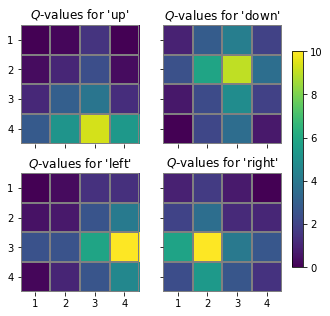

In [4]:
m = Maze()
a = MBAgent()
a.init_states(m)
a.q_planning(n=1000)

# Before the agent starts, it has perfect knowledge
plot_q_table(a, vmin=0, vmax=10)
plt.savefig("figures/qtable_qplanning.png")

### A Comparison of 1-steo $Q$-planning vs. $Q$-learning

To get a better sense of the difference between model-free and model-based RL, we can compare the path taken on its very first trial by an agent using 1-steo $Q$-planning and that of an agent that uses standard $Q$-learning. As expected, the model-based agent uses an efficient, optimal path right away, while the model-free agent will be left wandering about the maze until the first reward is found.

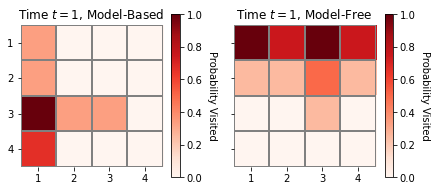

In [5]:
a.alpha=0.0
h = run_trials(m, a, 1)

a2 = MBAgent(alpha=0.0)
m2 = Maze()
h2 = run_trials(m2, a2, 1)

fig, axs = plt.subplots(1, 2, figsize=(7,3))
for ax in axs:
    ax.label_outer()
plot_history(h, ax=axs[0], title=r"Time $t=1$, Model-Based")
im, bar = plot_history(h2, ax=axs[1], title=r"Time $t=1$, Model-Free")

## Dyna-Q

The One-step Q-planning agent needs an internal model of the environment to start with. But what if the environment can be learned as we go? The idea is known as Dyna-$Q$. In this new agent, there is no neeed to intialize the internal model with a special function `init_states`. Instead, the code to update the $S$-table is directly embedded into the `learnQ` function.  

In [6]:
import random
import numpy as np

class DynaQ():
    def __init__(self, actions=Maze.ACTIONS, epsilon=0.1, alpha=0.1, gamma=0.9):
        """Creates a DynaQ-agent. Note that this agent learns the S-table as it explores"""
        self.Q = {}    ## Initial dictionary of (s, a) pairs. At the beginning, it's emtpy.
        self.S = {}    ## Initial model of the environment. At the beginning,  it's empty. 
        self.epsilon = epsilon     # Epsilon for e-greey policy
        self.alpha = alpha         # Learning rate
        self.gamma = gamma         # Temporal discounting
        self.actions = actions     # Set of possible actions (provide those of Maze.ACTIONS)

        
    def planning(self, n=10):
        """Plans ahead and learns the Q-table"""
        if len(self.S.keys()) > 0:
            for j in range(n):
                start = random.choice(tuple(self.S.keys()))
                state2, reward2 = self.S[start]
                action2 = random.choice(self.actions)
                state1, action1 = start
                self.dyna_q(state1, action1, reward2, state2, action2)

        
    def policy(self, state):
        """Selects an action with a epsilon-greedy policy"""
        # First, plan ahead with the basic environment as we know it
        self.planning(n=10)
        
        # Then, proceed with selecting an action
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
            
        else:
            q = [self.Q[(state, a)] if (state, a) in self.Q.keys() else 0.0 for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    
    def dyna_q(self, state1, action1, reward2, state2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha
        
        q1 = 0.0
        
        if (state1, action1) in self.Q.keys():
            q1 = self.Q[(state1, action1)]
        
        max_q2 = max([self.Q[(state2, a)] if (state2, a) in self.Q.keys() else 0.0 for a in self.actions])
        
        rpe = reward2 + g * max_q2 - q1
        q1 += a * rpe
        
        # Update the Q-table
        self.Q[(state1, action1)] = q1
        
        # Update the S-table
        if (state1, action1) in self.S.keys():
            self.S[(state1, action1)] = (state2, reward2)
            

def rl_loop(environment, agent):
    """A trial ends when the agent gets a reward. The history is returned"""
    state1 = environment.state
    action1 = agent.policy(state1)
    reward2 = 0.0
    history = [state1]
    while reward2 != 10:
        state2, reward2 = environment.transition(action1)
        action2 = agent.policy(state2)
        
        # Save the states visited
        history.append(state2)
        
        # Update the Q-values for state1, action1
        agent.dyna_q(state1, action1, reward2, state2)
        
        state1 = state2
        action1 = action2
        
    return history

### Testing Dyna-$Q$

Here is a simple test of Dyna-$Q$. Note that the new agent learns as it goes, but learns faster than a simple Q-agent.

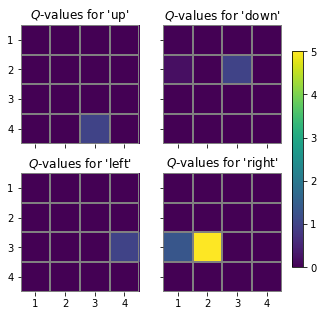

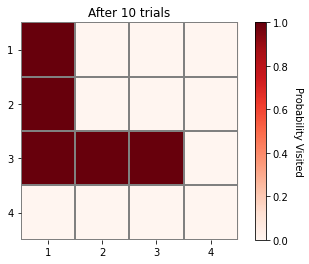

In [7]:
m = Maze()
a = DynaQ()

run_trials(m, a, 10)
plot_q_table(a, vmin=0, vmax=5)
plt.savefig("figures/qtable_dynaq.png")

fig, ax = plt.subplots(1,1)
h = run_trials(m, a, 3)
plot_history(h, ax=ax, title="After 10 trials")
plt.show()

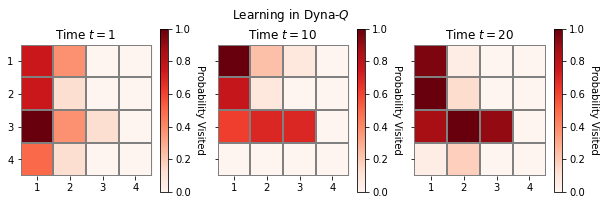

In [8]:
m = Maze()
a = DynaQ()

fig, axs = plt.subplots(1, 3, figsize=(10,3))

for x in axs:
    x.label_outer()

h1 = run_trials(m, a, 1)
h2 = run_trials(m, a, 9)
h3 = run_trials(m, a, 20)

plot_history(h1, ax=axs[0], title=r"Time $t=1$")
plot_history(h2, ax=axs[1], title=r"Time $t=10$")
plot_history(h3, ax=axs[2], title=r"Time $t=20$")
fig.suptitle(r"Learning in Dyna-$Q$")
plt.savefig("figures/dynaq_learning.png")

# Evidence for Model-Based Learning

The distinction between Model-Based and Model-Free learning is reminiscent of an old debate in the animal psychology literature, that between Tolman and Hull. In essence, Hull believed that all animal behavior could be explained by habit and associations, while Tolman maintained that animals could acquire some internal representation. This debate later morphed into a discussion on whether animals would learn Stimulus-Response (S-R) associations or Stimulus-Stimulus (S-S) associations. In RL terms, a S-R association is an entry in the $Q$-table, while a S-S association is an entry in the $S$-table. The latter is, of course, the basis of Model-Based RL.

But do animals use Model-Based RL?  Here is some data that Tolman (1948) reported in a review paper from an earlier experiment. Three groups of rats were tested: One did not receive a reward (NR), one received a reward at the end of the maze (R), and one group began receiving no reward, but switched to receiving rewards on Day 11 (NR-R). After the first reward was found, the latter group performed at the same level as the "R" group, suggesting that some form of learning had occurred in absence of a reward.

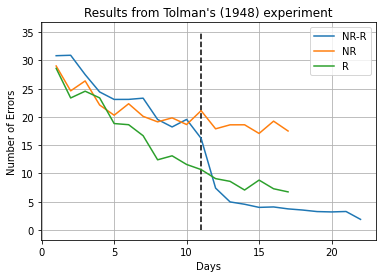

In [9]:
import pandas as pd
data = pd.read_csv("data/tolman_data.csv", header=None, names=("X", "Y"))
NR_R = data["Y"][0:22]
NR = data["Y"][22:22+17]
R = data["Y"][22+17:22+34]

plt.plot(range(1,23), NR_R)
plt.plot(range(1,18), NR)
plt.plot(range(1,18), R)
plt.grid(linestyle="-")
plt.legend(labels=("NR-R", "NR", "R"))
plt.xlabel("Days")
plt.ylabel("Number of Errors")
plt.vlines(x=11, ymin=0, ymax=35, colors="k", linestyle="--")
plt.title("Results from Tolman's (1948) experiment")
plt.savefig("figures/tolman1948.png")